## Importing data

In [ ]:
#import pandas as pd
#df = pd.io.stata.read_stata('/Users/elenaschigirev/Desktop/impic2016.dta')
#df.to_csv('/Users/elenaschigirev/Desktop/impic2016.csv')
#belgium = df[df['cntry'] == 'be']
#belgium

In [ ]:
import pandas as pd
data_file = "/Users/elenaschigirev/Desktop/lw_project/project_setup/immigration.xlsx"
df = pd.read_excel(data_file,
                     sheet_name=0,
                     header=0,
                     index_col=False,
                     keep_default_na=True)
df.head()

## Visualisation of trends

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

year = df['year']
total_immigr = df['total_immigr']
gdp_be = df['gdp_be']

plt.figure(figsize=(15,10))
plt.plot(year, total_immigr, label='total')
#plt.plot(year, gdp_be, label='gdp')
plt.legend()
plt.title('Immigration to Belgium')
plt.grid(lw=0.5)
plt.xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])
plt.show()

In [ ]:
gdp_be = df['gdp_be']

plt.figure(figsize=(15,5))
plt.plot(year, gdp_be, label='GDP Belgium')
plt.legend()
plt.title('GDP Comparison')
plt.grid(lw=0.5)
plt.xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])
plt.show()

In [ ]:
age_dep_be = df['age_dep_be']

plt.figure(figsize=(15,5))
plt.plot(year, age_dep_be, label='dep_rat_be')
plt.legend()
plt.title('Age dependency ratio comparison')
plt.grid(lw=0.5)
plt.xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])
plt.show()

The dependency ratio is a measure of the number of dependents aged zero to 14 and over the age of 65, compared with the total population aged 15 to 64. This demographic indicator gives insight into the number of people of non-working age, compared with the number of those of working age.

In [ ]:
sns.scatterplot('gdp_be', 'total_immigr', data=df)

In [ ]:
sns.regplot('gdp_be', 'total_immigr', data=df)

In [ ]:
print('R-Squared = ', (df.corr()['total_immigr']['gdp_be'])**2)

90% of the variance of immigration is explainable by the variance of Belgian GDP. Hm, that's quite high

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.regplot('gdp_be', 'total_immigr', data=df, ci=95)
plt.subplot(2,2,2)
sns.regplot('gdp_be', 'total_immigr', data=df.sample(10, random_state=6), ci=95)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt 
import numpy as np

model = smf.ols(formula='total_immigr ~ gdp_be', data=df)
model = model.fit()
model

In [ ]:
print(model.params)

Interpretation: For each increase of 1 unit of GDP, immigration increases on average by...hmmm

## Multiple Linear Regression Analysis

In [ ]:
#df['year'] = pd.to_datetime(df['year'], infer_datetime_format=True)
#df.head()
indexed_df = df.set_index(['year'])
indexed_df.head()

In [ ]:
indexed_df = indexed_df.astype(float)

In [ ]:
indexed_df = indexed_df.loc['1977':'2018']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pylab
import math

from scipy import stats

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

In [ ]:
display(indexed_df.isnull().any())

In [ ]:
select_df = indexed_df[['total_immigr', 'work_age_be', 'pop_growth_be', 'age_dep_be', 'gdp_be', 'gdp_capita_be', 'pol_change_minor', 'pol_change_mid', 'pol_change_major']]
select_df.head()

Assumptions that led to the inclusion of above independent variables:

work_age_be: if the working age population is decreasing, more jobs will remain unfilled and the state will accept more migrants

pop_growth_be: if the population growth slows down there will be more need to attract foreigners

age_dep_be: ratio of working people and dependent people (children, retired, etc.), similar to work_age_be so we expect a high correlation

gdp_be: a wealthier country will attract more migrants

changes in immigration policies affect how many migrants will be able to enter


In [ ]:
corr = select_df.corr()
display(corr)

sns.heatmap(corr, 
            xticklabels = corr.columns, 
            yticklabels = corr.columns,
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True)

Very high correlations between:

immigration and pop_growth: immigration might have positive impact on fertility (pop_growth = births - deaths)

immigration and gdp: need to check the formula of gdp

work_age_be and age_dep_be: as expected, see above

Let's remove highly collinear variables

In [ ]:
df_before = select_df
df_after = select_df[['total_immigr', 'work_age_be', 'pop_growth_be', 'gdp_capita_be', 'pol_change_minor', 'pol_change_mid', 'pol_change_major']]

#Adding a constant
X1 = sm.tools.add_constant(df_before)
X2 = sm.tools.add_constant(df_after)

#Create a series for both
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index = X1.columns)
series_after = pd.Series([variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])], index = X2.columns)

#Display the series
print('DATA BEFORE')
print('-'*100)
display(series_before)

print('DATA AFTER')
print('-'*100)
display(series_after)

In [ ]:
X = df_after.drop('total_immigr', axis=1)
y = df_after[['total_immigr']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

lin_model = LinearRegression()

lin_model.fit(X_train, y_train)

### Exploring the output

In [ ]:
intercept = lin_model.intercept_[0]
coef = lin_model.coef_[0]

print("The intercept for our model is {:.4}".format(intercept))
print("-"*100)

# Loop through the dictionary and print the data
for cf in zip(X.columns, coef):
    print("The coefficient for {} is {:.2}".format(cf[0],cf[1]))

In [ ]:
# Get multiple predictions
y_predict = lin_model.predict(X_test)

# show the first five
y_predict[:5]

### Evaluating the model

In [ ]:
# define our input
X2 = sm.add_constant(X)

# create an OLS model
model = sm.OLS(y, X2)

# fit the data
est = model.fit()

In [ ]:
# Checking for heteroscedasticity
_, pval, _, f_pval = diag.het_white(est.resid, est.model.exog)
print(pval, f_pval)
print("-"*50)

# Print the results of the test
if pval > 0.05:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypothesis, so there is no heteroscedasticity. \n")

else:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypothesis, so there is heteroscedasticity. \n")
    
_, pval, _, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print("-"*50)

# Print the results of the test
if pval > 0.05:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypothesis, so there is no heteroscedasticity. \n")

else:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypothesis, so there is heteroscedasticity. \n")
    

In [ ]:
# Checking for autocorrelation

# calculate the lag
lag = min(10, (len(X)// 5))
print('The number of lags will be {}'.format(lag))
print('.'*100)

# perform Ljung-box test
test_results = diag.acorr_ljungbox(est.resid, lags = lag)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypothesis, so there is no autocorrelation.")
    print("."*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypothesis, so there is autocorrelation.")
    print("."*100)
    
# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

### Checking for normally distributed residuals

In [ ]:
# Checking that the mean of the residuals equals 0
import pylab
sm.qqplot(est.resid, line = 's')
pylab.show()

# Check that the mean of the residuals is approx. 0
mean_residuals = sum(est.resid) / len(est.resid)
mean_residuals

### Measures of error

In [ ]:
import math 
#calculate the mean squared error
model_mse = mean_squared_error(y_test, y_predict)

#calculate the mean absolute error
model_mae = mean_absolute_error(y_test, y_predict)

#calculate the root mean squared error
model_rmse = math.sqrt(model_mse)

#display the output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

R-Squared

In [ ]:
model_r2 = r2_score(y_test, y_predict)
model_r2

Confidence intervals

In [ ]:
est.conf_int()

Hypothesis testing

In [ ]:
est.pvalues

Create a summary of the model output

In [ ]:
print(est.summary())

Remove the insignificant variables (to be done)

In [ ]:
df_after = select_df[['total_immigr', 'work_age_be', 'pop_growth_be', 'gdp_capita_be', 'pol_change_minor', 'pol_change_mid', 'pol_change_major']]
#df_after = select_df.drop(['total_immigr', 'work_age_be', 'pop_growth_be', 'gdp_capita_be', 'pol_change_minor', 'pol_change_mid', 'pol_change_major'], axis = 1)

X = df_after.drop('total_immigr', axis=1)
y = df_after[['total_immigr']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

lin_model = LinearRegression()

lin_model.fit(X_train, y_train)

In [ ]:
# define our input
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(y, X2)

# fit the data
est = model.fit()

print(est.summary())

### Save the model for future use

In [ ]:
import pickle

# pickle the model
with open('multilinear_regression.sav', 'wb') as f:
    pickle.dump(lin_model, f)

# load it back in
with open ('multilinear_regression.sav', 'rb') as pickle_file:
    lin_model_2 = pickle.load(pickle_file)

In [ ]:
# make a new prediction
#lin_model.predict([X_test.loc[?]])

## VAR Model

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pylab
import math

from scipy import stats

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


import datetime as dt
from datetime import datetime

#!pip install keras

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [25]:
data_file = "/Users/elenaschigirev/Desktop/lw_project/project_setup/immigration.xlsx"
df = pd.read_excel(data_file,
                     sheet_name=0,
                     header=0,
                     index_col=False,
                     keep_default_na=True)

In [26]:
data = df[['year',
           'total_immigr',
           'total_pop_be',
           'pop_change_be',
           'work_age_be',
           'pop_growth_be',
           'life_ex_be',
           'age_dep_be',
           'gdp_be',
           'gdp_capita_be',
           'rur_pop_be',
           'pol_change_minor',
           'pol_change_mid',
           'pol_change_major',
           'unempl_rate',
           'gni',
           'gni_capita',
           'fert_rate']]

data.head()

,year,total_immigr,total_pop_be,pop_change_be,work_age_be,pop_growth_be,life_ex_be,age_dep_be,gdp_be,gdp_capita_be,rur_pop_be,pol_change_minor,pol_change_mid,pol_change_major,unempl_rate,gni,gni_capita,fert_rate
0,1977,55298,9830358,9315,64.188460,0.123480,72.773902,55.791254,2.427833e+11,24697.300167,5.194,0,0,0,6.3,8.080847e+10,8220,1.71
1,1978,52594,9839534,6923,64.523219,0.093300,72.698049,54.982970,2.496830e+11,25375.485530,4.995,0,1,0,6.8,9.408408e+10,9560,1.69
2,1979,54854,9848382,11502,64.932801,0.089883,73.193659,54.005361,2.555282e+11,25946.212578,4.804,0,0,0,7.0,1.155627e+11,11730,1.69
3,1980,54694,9859243,10430,65.413216,0.110211,73.207073,52.874312,2.668840e+11,27069.426306,4.619,0,0,0,7.4,1.378263e+11,13980,1.68
4,1981,49298,9858982,11519,65.870820,-0.002637,73.621707,51.812296,2.661387e+11,26994.537714,4.465,0,0,1,9.4,1.300799e+11,13190,1.66


In [27]:
data['year'] = pd.to_datetime(df['year'], format='%Y')
data.head()

/Users/elenaschigirev/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,year,total_immigr,total_pop_be,pop_change_be,work_age_be,pop_growth_be,life_ex_be,age_dep_be,gdp_be,gdp_capita_be,rur_pop_be,pol_change_minor,pol_change_mid,pol_change_major,unempl_rate,gni,gni_capita,fert_rate
0,1977-01-01,55298,9830358,9315,64.188460,0.123480,72.773902,55.791254,2.427833e+11,24697.300167,5.194,0,0,0,6.3,8.080847e+10,8220,1.71
1,1978-01-01,52594,9839534,6923,64.523219,0.093300,72.698049,54.982970,2.496830e+11,25375.485530,4.995,0,1,0,6.8,9.408408e+10,9560,1.69
2,1979-01-01,54854,9848382,11502,64.932801,0.089883,73.193659,54.005361,2.555282e+11,25946.212578,4.804,0,0,0,7.0,1.155627e+11,11730,1.69
3,1980-01-01,54694,9859243,10430,65.413216,0.110211,73.207073,52.874312,2.668840e+11,27069.426306,4.619,0,0,0,7.4,1.378263e+11,13980,1.68
4,1981-01-01,49298,9858982,11519,65.870820,-0.002637,73.621707,51.812296,2.661387e+11,26994.537714,4.465,0,0,1,9.4,1.300799e+11,13190,1.66


In [28]:
data = data.set_index(['year'])
data.head()

,total_immigr,total_pop_be,pop_change_be,work_age_be,pop_growth_be,life_ex_be,age_dep_be,gdp_be,gdp_capita_be,rur_pop_be,pol_change_minor,pol_change_mid,pol_change_major,unempl_rate,gni,gni_capita,fert_rate
year,,,,,,,,,,,,,,,,,
1977-01-01,55298,9830358,9315,64.188460,0.123480,72.773902,55.791254,2.427833e+11,24697.300167,5.194,0,0,0,6.3,8.080847e+10,8220,1.71
1978-01-01,52594,9839534,6923,64.523219,0.093300,72.698049,54.982970,2.496830e+11,25375.485530,4.995,0,1,0,6.8,9.408408e+10,9560,1.69
1979-01-01,54854,9848382,11502,64.932801,0.089883,73.193659,54.005361,2.555282e+11,25946.212578,4.804,0,0,0,7.0,1.155627e+11,11730,1.69
1980-01-01,54694,9859243,10430,65.413216,0.110211,73.207073,52.874312,2.668840e+11,27069.426306,4.619,0,0,0,7.4,1.378263e+11,13980,1.68
1981-01-01,49298,9858982,11519,65.870820,-0.002637,73.621707,51.812296,2.661387e+11,26994.537714,4.465,0,0,1,9.4,1.300799e+11,13190,1.66


In [30]:
data_before = data
data_after = data.drop(['total_pop_be', 
                        'pop_change_be', 
                        'work_age_be', 
                        'pop_growth_be', 
                        'life_ex_be', 
                        'gdp_be',
                        'gdp_capita_be',
                        'rur_pop_be',
                        'gni'], axis=1)

#Adding a constant
X1 = sm.tools.add_constant(data_before)
X2 = sm.tools.add_constant(data_after)

#Create a series for both
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index = X1.columns)
series_after = pd.Series([variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])], index = X2.columns)

#Display the series
print('DATA BEFORE')
print('-'*100)
display(series_before)

print('DATA AFTER')
print('-'*100)
display(series_after)

DATA BEFORE
----------------------------------------------------------------------------------------------------


/Users/elenaschigirev/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const                    0.000000
total_immigr           136.170762
total_pop_be         10315.207319
pop_change_be           31.291986
work_age_be            449.282145
pop_growth_be           12.135455
life_ex_be             821.465536
age_dep_be             714.324715
gdp_be              111881.021276
gdp_capita_be        83090.849299
rur_pop_be            1301.346614
pol_change_minor         1.479338
pol_change_mid           1.876262
pol_change_major         1.436313
unempl_rate              5.398674
gni                  49580.968697
gni_capita           40777.631655
fert_rate               57.607227
dtype: float64

DATA AFTER
----------------------------------------------------------------------------------------------------


const               2082.573778
total_immigr          16.434618
age_dep_be             1.799472
pol_change_minor       1.269474
pol_change_mid         1.247276
pol_change_major       1.210892
unempl_rate            1.634644
gni_capita            13.794361
fert_rate              3.026355
dtype: float64

In [31]:
# Setting all values to float
data_after = data_after.astype(float)
data_after.head()

,total_immigr,age_dep_be,pol_change_minor,pol_change_mid,pol_change_major,unempl_rate,gni_capita,fert_rate
year,,,,,,,,
1977-01-01,55298.0,55.791254,0.0,0.0,0.0,6.3,8220.0,1.71
1978-01-01,52594.0,54.982970,0.0,1.0,0.0,6.8,9560.0,1.69
1979-01-01,54854.0,54.005361,0.0,0.0,0.0,7.0,11730.0,1.69
1980-01-01,54694.0,52.874312,0.0,0.0,0.0,7.4,13980.0,1.68
1981-01-01,49298.0,51.812296,0.0,0.0,1.0,9.4,13190.0,1.66


In [33]:
# Feature scaling 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_after[['total_immigr', 'age_dep_be', 'unempl_rate', 'gni_capita', 'fert_rate']] = scaler.fit_transform(data_after[['total_immigr', 'age_dep_be', 'unempl_rate', 'gni_capita', 'fert_rate']])

data_after.head()

,total_immigr,age_dep_be,pol_change_minor,pol_change_mid,pol_change_major,unempl_rate,gni_capita,fert_rate
year,,,,,,,,
1977-01-01,0.108133,0.990045,0.0,0.0,0.0,0.000000,0.000000,0.571429
1978-01-01,0.083016,0.888458,0.0,1.0,0.0,0.106383,0.033787,0.514286
1979-01-01,0.104009,0.765591,0.0,0.0,0.0,0.148936,0.088502,0.514286
1980-01-01,0.102523,0.623440,0.0,0.0,0.0,0.234043,0.145234,0.485714
1981-01-01,0.052399,0.489964,0.0,0.0,1.0,0.659574,0.125315,0.428571


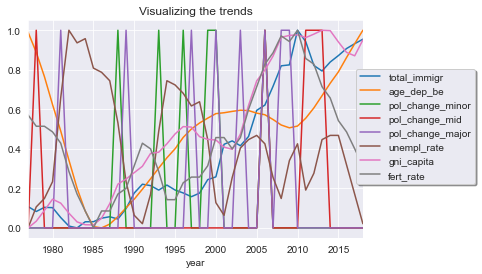

In [64]:
#Visualize what variables are changing with time and how they are changing (trends)
sns.set_style('darkgrid')
data_after.plot(kind = 'line', legend = 'reverse', title = 'Visualizing the trends')
plt.legend(loc = 'upper right', shadow = True, bbox_to_anchor = (1.35, 0.8))
plt.show()

Checking for stationarity

In [45]:
# Splitting the dataset into train & test subsets
n_obs = 5
train_set, test_set = data_after[:-n_obs], data_after[-n_obs:]

# Augmented Dickey-Fuller Test (ADF Test) to check for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(data_after):
    dftest = adfuller(data_after, autolag='AIC')
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")


for i in train_set.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(train_set[i])
    print('\n')


Column:  total_immigr
--------------------------------------
Test Statistic           0.246532
p-value                  0.974754
# Lags                   0.000000
# Observations          36.000000
Critical Value (1%)     -3.626652
Critical Value (5%)     -2.945951
Critical Value (10%)    -2.611671
dtype: float64

Series is Non-Stationary


Column:  age_dep_be
--------------------------------------
Test Statistic          -1.860944
p-value                  0.350651
# Lags                   2.000000
# Observations          34.000000
Critical Value (1%)     -3.639224
Critical Value (5%)     -2.951230
Critical Value (10%)    -2.614447
dtype: float64

Series is Non-Stationary


Column:  pol_change_minor
--------------------------------------
Test Statistic          -4.948717
p-value                  0.000028
# Lags                   1.000000
# Observations          35.000000
Critical Value (1%)     -3.632743
Critical Value (5%)     -2.948510
Critical Value (10%)    -2.613017
dtype: float64


In [46]:
# Differencing all variables to get rid of Stationarity
data_differenced = train_set.diff().dropna()

In [47]:
# Running the ADF test once again to test for Stationarity
for i in data_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(data_differenced[i])
    print('\n')

Column:  total_immigr
--------------------------------------
Test Statistic          -4.792333
p-value                  0.000056
# Lags                   0.000000
# Observations          35.000000
Critical Value (1%)     -3.632743
Critical Value (5%)     -2.948510
Critical Value (10%)    -2.613017
dtype: float64

Series is Stationary


Column:  age_dep_be
--------------------------------------
Test Statistic          -2.360585
p-value                  0.153171
# Lags                   1.000000
# Observations          34.000000
Critical Value (1%)     -3.639224
Critical Value (5%)     -2.951230
Critical Value (10%)    -2.614447
dtype: float64

Series is Non-Stationary


Column:  pol_change_minor
--------------------------------------
Test Statistic          -4.436580
p-value                  0.000256
# Lags                   5.000000
# Observations          30.000000
Critical Value (1%)     -3.669920
Critical Value (5%)     -2.964071
Critical Value (10%)    -2.621171
dtype: float64

Ser

In [48]:
# Still non-stationary: total_immigr, age_dep_be, gni_capita
data_differenced = data_differenced.diff().dropna()

In [49]:
# Running the ADF test for the 3rd time to test for Stationarity
for i in data_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(data_differenced[i])
    print('\n')

Column:  total_immigr
--------------------------------------
Test Statistic         -7.198102e+00
p-value                 2.404930e-10
# Lags                  1.000000e+00
# Observations          3.300000e+01
Critical Value (1%)    -3.646135e+00
Critical Value (5%)    -2.954127e+00
Critical Value (10%)   -2.615968e+00
dtype: float64

Series is Stationary


Column:  age_dep_be
--------------------------------------
Test Statistic          -3.011778
p-value                  0.033809
# Lags                   0.000000
# Observations          34.000000
Critical Value (1%)     -3.639224
Critical Value (5%)     -2.951230
Critical Value (10%)    -2.614447
dtype: float64

Series is Stationary


Column:  pol_change_minor
--------------------------------------
Test Statistic          -5.594241
p-value                  0.000001
# Lags                   6.000000
# Observations          28.000000
Critical Value (1%)     -3.688926
Critical Value (5%)     -2.971989
Critical Value (10%)    -2.625296
dt

/Users/elenaschigirev/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


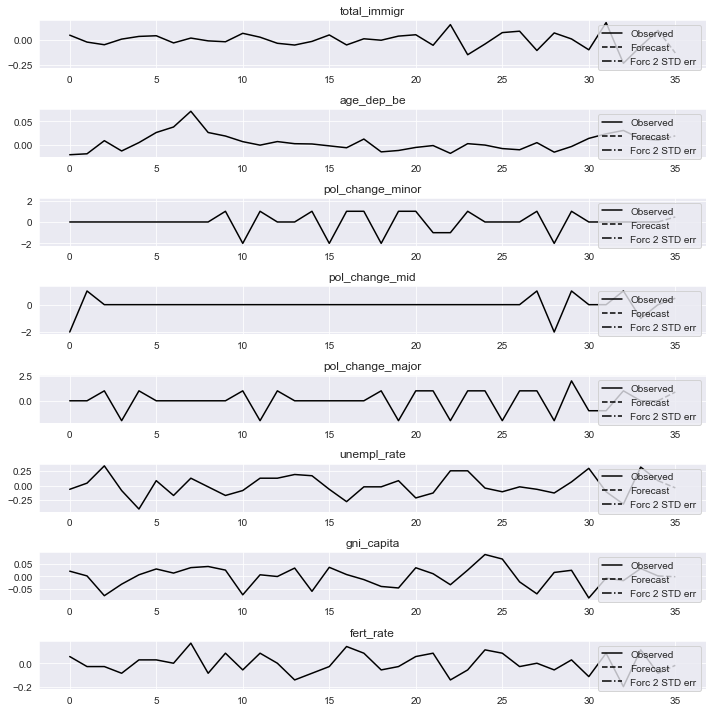

In [54]:
# Fitting the VAR model to the Differenced Data
from statsmodels.tsa.api import VAR

model = VAR(data_differenced)
results = model.fit(maxlags = 1, ic = 'aic')
results.summary()

# Forecasting for 5 steps ahead
lag_order = results.k_ar
predicted = results.forecast(data_differenced.values[-lag_order:], n_obs)
forecast = pd.DataFrame(predicted, index = data_after.index[-n_obs:], columns = data_after.columns)

# Plotting the Forecasted values
p1 = results.plot_forecast(1)
p1.tight_layout()

# Inverting the Differencing Transformation
def invert_transformation(data_after, df_forecast, second_diff=False):
    for col in data_after.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (data_after[col].iloc[-1] - data_after[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = data_after[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

forecast_values = invert_transformation(train_set, forecast, second_diff=True)

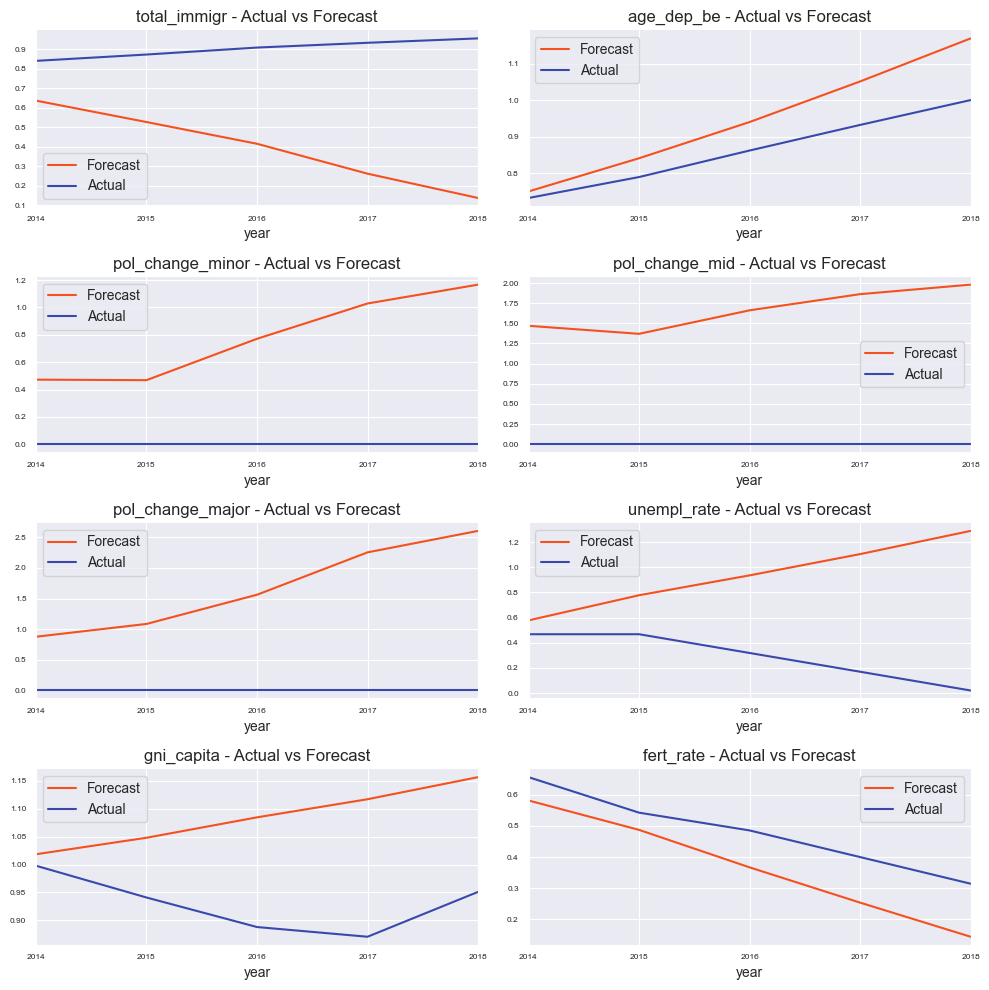

In [61]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(data_after.columns)/2), ncols = 2, dpi = 100, figsize = (10,10))

for i, (col,ax) in enumerate(zip(data_after.columns, axes.flatten())):
    forecast_values[col].plot(color = '#F4511E', legend = True, ax = ax, label="Forecast").autoscale(axis =' x',tight = True)
    test_set[col].plot(color = '#3949AB', legend = True, ax = ax, label="Actual")

    ax.set_title(col + ' - Actual vs Forecast')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

In [58]:
# MSE
from sklearn.metrics import mean_squared_error
from numpy import asarray as arr
mse = mean_squared_error(test_set, forecast_values)